In [1]:
import warnings
from ipywidgets import Button, Layout
from datetime import datetime
# warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.patches as mpatches
from pprint import pprint
import numpy as np
from ipywidgets import HBox, VBox, interactive
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from IPython.display import display, Markdown
import ipywidgets as widgets
import math
import torch
from ipywidgets import interact, interact_manual
from IPython.display import set_matplotlib_formats
from importlib import reload
from pathlib import Path
from tqdm import tqdm

import sys
import os
sys.path.insert(0, os.path.abspath('../src/'))

import model_codebase as cb
import cicids2017 as cicids2017
import data_generator as generator

reload(cicids2017)
reload(generator)

pd.set_option('display.max_rows', 500)
pd.set_option('float_format', '{:.4f}'.format)

MODELPATH = Path("../res/ts2vec.torch")
DATASETPATH_CACHE = Path("../dataset/cache")
DATASETPATH = Path("../dataset/CICIDS2017_ntop.pkl")

/Users/swedishhdcamera/Desktop/Projects/tesi_sabella/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/swedishhdcamera/Desktop/Projects/tesi_sabella/venv/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [13]:
M = 254
MAX_ENC = M + math.pow(M, 2) + math.pow(M, 3)

def encdec(rgb=None, i=None):
    """
    References:
        https://coderwall.com/p/fzni3g/bidirectional-translation-between-1d-and-3d-arrays
    """
    if rgb is not None:
        i = rgb[0] + rgb[1] * M + rgb[2] * math.pow(M, 2)
        return math.floor(i)
    x = math.floor(i % M)
    y = math.floor((i / M) % M)
    z = math.floor(i / ( math.pow(M, 2) ))
    return (x, y, z)
           
def ncolors(n, givehex=False):
    cols = np.linspace(0, MAX_ENC, n)
    cols = map(lambda x: encdec(i=x), cols)
    
    if givehex:
        cols = map(lambda x: rgbtohex(*x), cols)
    return list(cols)
    
def rgbtohex(r, g, b):
    hexcol = "#{:02x}{:02x}{:02x}".format(r,g,b)
    return hexcol.upper()

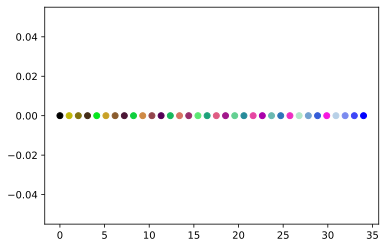

In [14]:
mu = 0
sigma = 1
N = 34

xs = np.linspace(0, N, N) # np.random.normal(mu, sigma, N)
ys = np.zeros(N) # np.random.normal(mu, sigma, N)
normcmap = ncolors(N, givehex=True)

plt.scatter(xs, ys, color=normcmap)

In [2]:
def mprint(s):
    display(Markdown(s))
    
def randcolors(n):
    hexl = list('0123456789ABCDEF')
    hexc = np.random.choice(hexl, size=(n, 6))
    return ['#' + ''.join(x) for x in hexc]
    
def describe_mtimeseries(key, mtimeserie, attack_meta=None):
    mprint(f"### {key}")
    # Data description ..... #
    start = min(mtimeserie.index)
    end = max(mtimeserie.index)
    mprint(f"**Time range**: {start} **/** {end}")
    mprint(f"**Total data range:** {end-start}")
    mprint(f"**Samples shown**: {len(mtimeserie)}")

    # Plotting clean data ..... #
    empty_cols = []
    for idx, c in enumerate(mtimeserie.columns):
        legend = [c]
        if (mtimeserie[c] == 0).all(): 
            empty_cols.append(c)
            continue
        plt.figure()
        ax = mtimeserie[c].plot(label=c, figsize=(8, 4))
        if attack_meta is not None:
            attack = attack_meta[attack_meta != "none"]
            for aname, adf in attack.groupby(attack):
                legend.append(aname)
                attack_data = mtimeserie.loc[adf.index]
                attack_data.plot(ax=ax, label=aname)
        plt.gcf().suptitle(f"{key}")
        plt.legend(legend)
        plt.show()
    for c in empty_cols:
        mprint(f"**<span style='color: red'>Empty series:</span> {c}**")
    
    mprint(f"<br>{'-'*50}<br>{'-'*50}<br>")

# Deltas

In [ ]:
df = pd.read_pickle(DATASETPATH)
min_delta = np.timedelta64(15, "s")

host_groups = df.groupby(['device_category', 'host'])
for (c, h), host_samples in host_groups:
    times = host_samples.index.get_level_values("_time").sort_values(ascending=True)
    delta = times.to_series().diff()[1:]
    delta_gap = filter(lambda x: x[1] > min_delta, enumerate(delta))

    for (i, gap) in delta_gap:
        if times[i].hour == 17:
            continue
        print(f"{c}:{h} / {times[i]} to {times[i+1]}")

# Plotting

We preprocess the data before showing it

In [ ]:
df = pd.read_pickle(DATASETPATH)
pr = cicids2017.Cicids2017Preprocessor(deltas=True, discretize=False, flevel="MAGIK")
df_preproc = pr.preprocessing(df, update=True)

In [ ]:
%matplotlib inline
set_matplotlib_formats('svg')

days = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Tursday": 3,
    "Friday": 4}

idxs = df_preproc.index.droplevel(2).unique()
devices = [f"{host} ({cat})" for cat, host in idxs]
devices.sort()
cols = list(df_preproc.columns)
cols.sort()


# ----- ----- WIDGETS ----- ----- #
# ----- ----- ------- ----- ----- #
device_w_list = widgets.Dropdown(options=devices,
                                 value="192.168.10.50 (server)")
days_w_list = widgets.Dropdown(options=list(days.keys()),
                               value="Monday")
selectedc_w_list = widgets.SelectMultiple(options=cols,
                                          value=["unreachable_flows:flows_as_client"],
                                          description='Features',
                                          layout=Layout(width='400px'))
showall_checkbox = widgets.Checkbox(value=False, description='Show all features')
timerange_slider = widgets.FloatSlider(min=.01, max=1., step=.01)
offset_slider = widgets.FloatSlider(min=.0, max=1., step=.01)
ts_selector = HBox([device_w_list, days_w_list])
col_selector = HBox([selectedc_w_list, showall_checkbox])
ts_shifting = HBox([timerange_slider, offset_slider])
wlist = VBox([ts_selector, col_selector, ts_shifting])


# ----- ----- INTERACTOR ----- ----- #
# ----- ----- ------- ----- ----- #
def whandler(device, day, column, showall, trange, offset):
    split = device.split(" ")
    columns = list(column)
    host = split[0].strip()
    category = " ".join(split[1:]).replace("(", "").replace(")", "").strip()
    host_ts = df_preproc.loc[category, host]
    # Filterign day of week
    host_ts = host_ts[host_ts.index.dayofweek==days[day]]
    # Filtering time range
    ts_len = len(host_ts)
    start_idx = int(ts_len * offset)
    end_idx = min(start_idx + int(ts_len * trange), ts_len)
    
    selected_features = cols if showall else columns
    attack =  host_ts.iloc[start_idx:end_idx]["attack"] if "attack" in cols else None
    describe_mtimeseries(device.strip(), 
                         host_ts.iloc[start_idx:end_idx][selected_features],
                         attack)



output = widgets.interactive(whandler,
                        device=device_w_list, day=days_w_list, 
                        column=selectedc_w_list, showall=showall_checkbox, 
                        trange=timerange_slider, offset=offset_slider).children[-1]
display(wlist)
display(output)

# Visualization from cache

In [84]:
from umap import UMAP

ts2vec = cb.STC().eval()
ts2vec.load_state_dict(torch.load(str(MODELPATH), map_location=torch.device('cpu')))

_, dset, _ = cicids2017.load_dataset(DATASETPATH_CACHE)
X = torch.Tensor(dset["context"])
actv = X[:, :cb.ACTIVITY_LEN]

with torch.no_grad():    
    dset["embedding"] = ts2vec.toembedding(actv).numpy()

dset["UMAP"] = UMAP().fit_transform(dset["embedding"])

timestamp2weekday = lambda x: datetime.fromtimestamp(x).weekday()
dset_day = list(map(timestamp2weekday, dset["start_time"]))
dset["weekday"] = np.array(dset_day)

In [110]:
%matplotlib inline
set_matplotlib_formats('svg')

DAY2INT = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4}
INT2DAY = {v: k for k, v in DAY2INT.items()}

devices = set([(c, h) for (c, h) in zip(dset["device_category"], dset["host"])])
devices_str = [f"{h} ({c})" for c, h in devices]
devices_str.sort()


# ----- ----- COLORMAPS ----- ----- #
# ----- ----- ------- ----- ----- #
hosts = [dev[1] for dev in devices]
host_cmap = dict(zip(hosts, ncolors(len(hosts), givehex=True)))

cats = [dev[0] for dev in devices]
cats_cmap = dict(zip(cats, ncolors(len(cats), givehex=True)))

attacks = np.unique(dset["attack"])
attack_cmap = dict(zip(attacks, ncolors(len(attacks), givehex=True)))


# ----- ----- WIDGETS ----- ----- #
# ----- ----- ------- ----- ----- #
device_w_list = widgets.Dropdown(options=devices_str,
                                 value="192.168.10.50 (server)")

available_days = list(map(lambda x: INT2DAY[x], np.unique(dset["weekday"])))
days_w_list = widgets.Dropdown(options=available_days)

netmap_checkbox = widgets.Checkbox(value=False, description='Show all network')
show_ip_checkbox = widgets.Checkbox(value=False, description='Show specific IP')
ts1_selector = HBox([device_w_list, netmap_checkbox])
ts2_selector = HBox([days_w_list, show_ip_checkbox])
wlist = VBox([ts1_selector, ts2_selector])

In [121]:
# ----- ----- INTERACTOR ----- ----- #
# ----- ----- ------- ----- ----- #
def whandler(device, day, netmap, show_ip):
    idx_mask = (dset["weekday"] == DAY2INT[day])
    
    host_only = not netmap
    if host_only:
        # Extracting host/category
        split = device.split(" ")
        host = split[0].strip()
        category = " ".join(split[1:]).replace("(", "").replace(")", "").strip()
        # Masking
        host_mask = (dset["host"]==host)
        idx_mask = idx_mask & host_mask      
    x1 = dset["UMAP"][:, 0]
    x2 = dset["UMAP"][:, 1]
    
    if not netmap:
        focus_label, cmap = ("attack", attack_cmap)
    elif netmap:
        if show_ip:
            focus_label, cmap = ("host", host_cmap) 
        else:
            focus_label, cmap = ("device_category", cats_cmap) 
    colors = np.array(list(map(lambda x: cmap[x], dset[focus_label])))
    labels = dset[focus_label]
    
    # Plotting ..... #
    ax = plt.gca()
    for l in np.unique(labels):
        l_idxs = np.where(labels==l)[0]
        ax.scatter(x1[l_idxs], x2[l_idxs], color=colors[l_idxs], label=l)
    plt.legend(loc=(1.04,0))
    plt.gcf().set_size_inches(7, 7)
    plt.show()

output = widgets.interactive(whandler,
                        device=device_w_list, day=days_w_list, 
                        netmap=netmap_checkbox, show_ip=show_ip_checkbox).children[-1]
display(wlist)
display(output)

Output()

# Embedding from dataset

In [9]:
df = pd.read_pickle(DATASETPATH)
pr = cicids2017.Cicids2017Preprocessor(deltas=True, discretize=False, flevel="NF_BLMISC")
df_preproc = pr.preprocessing(df, update=False)

ts2vec = cb.STC()
ts2vec.load_state_dict(torch.load(str(MODELPATH), map_location=torch.device('cpu')))

/Users/swedishhdcamera/Desktop/Projects/tesi_sabella/venv/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


<All keys matched successfully>

In [6]:
%matplotlib inline
set_matplotlib_formats('svg')

days_keys = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4}

idxs = df_preproc.index.droplevel(2).unique()
devices = [f"{host} ({cat})" for cat, host in idxs]
devices.sort()


# ----- ----- COLORMAPS ----- ----- #
# ----- ----- ------- ----- ----- #
hosts = df_preproc.index.get_level_values("host").unique()
host_cmap = dict(zip(hosts, ncolors(len(hosts), givehex=True)))
categories = df_preproc.index.get_level_values("device_category").unique()
dev_cat_cmap = dict(zip(categories, ncolors(len(categories), givehex=True)))
attacks = df_preproc["attack"].unique()
attack_cmap = dict(zip(attacks, randcolors(len(attacks))))


# ----- ----- WIDGETS ----- ----- #
# ----- ----- ------- ----- ----- #
device_w_list = widgets.Dropdown(options=devices,
                                 value="192.168.10.50 (server)")
days_w_list = widgets.Dropdown(options=list(days_keys.keys()),
                               value="Monday")
netmap_checkbox = widgets.Checkbox(value=False, description='Show all network')
show_ip_checkbox = widgets.Checkbox(value=False, description='Show specific IP')
ts1_selector = HBox([device_w_list, netmap_checkbox])
ts2_selector = HBox([days_w_list, show_ip_checkbox])
wlist = VBox([ts1_selector, ts2_selector])


# ----- ----- INTERACTOR ----- ----- #
# ----- ----- ------- ----- ----- #
def whandler(device, day, netmap, show_ip):
    host_only = not netmap
    daydf = df_preproc[df_preproc.index.get_level_values("_time").dayofweek == days_keys[day]]
    if host_only:
        split = device.split(" ")
        host = split[0].strip()
        category = " ".join(split[1:]).replace("(", "").replace(")", "").strip()
        daydf = daydf.loc[category, host]
    
    pts = cb.network2D(ts2vec, daydf, overlapping=.75)
    if not netmap:
        label, cmap = ("attack", attack_cmap)
    elif netmap:
        if show_ip:
            label, cmap = ("host", host_cmap) 
        else:
            label, cmap = ("device_category", dev_cat_cmap) 
    pts["color"] = pts[label].map(cmap)
    
    # Plotting ..... #
    ax = plt.gca()
    for l, vs in pts.groupby(label):
        ax.scatter(vs["x1"].values, vs["x2"].values, 
                    color=vs["color"].values, label=l)
    plt.legend(loc=(1.04,0))
    plt.gcf().set_size_inches(7, 7)
    plt.show()

output = widgets.interactive(whandler,
                        device=device_w_list, day=days_w_list, 
                        netmap=netmap_checkbox, show_ip=show_ip_checkbox).children[-1]
display(wlist)
display(output)

Output()